In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch.nn import init
from torchvision import transforms
import time
from tqdm.auto import tqdm

In [2]:
class img_data(Dataset):
    def __init__(self, path, option):
            data = pd.read_csv(path,header=None)
            
            self.items = [(data[i] ,int(path.split(option)[-1].replace(".csv",""))) for i in data]
            self.length = len(data.columns) # item의 개수
            self.to_tensor = transforms.ToTensor()
            
    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return self.length
    
    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        
        series_data, class_id = self.items[idx]
        
        eps=0.1
        steps=5
        N = series_data.size
        S = np.repeat(series_data[None,:],N, axis=0)
        image = np.floor(np.abs(S-S.T)/eps)
        image[image>steps] = steps
        image = self.to_tensor(image)
        
        
        return image, class_id

In [3]:
PATH = 'data/wonHR1.csv'
train = img_data(PATH,"HR")

In [4]:
train.__getitem__(1)[0].shape

/tmp/ipykernel_4155440/1448392316.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  S = np.repeat(series_data[None,:],N, axis=0)


torch.Size([1, 100, 100])

/tmp/ipykernel_4155440/1448392316.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  S = np.repeat(series_data[None,:],N, axis=0)


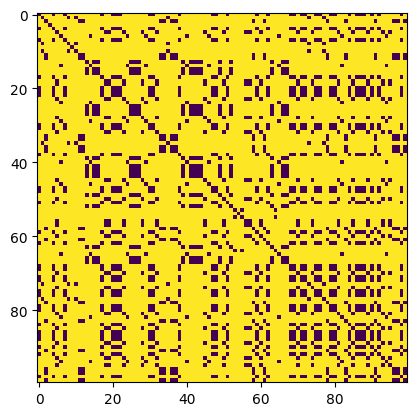

In [5]:
plt.imshow(train.__getitem__(1)[0][0])

In [6]:
# Hyper parameter
batch_size = 1
num_epochs=1
learning_rate = 0.001

In [7]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_esc50, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [48]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class Classifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=2)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

        # Dropout
        # self.dropout = nn.Dropout(0.25)

 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Dropout
        # x = self.dropout(x) 

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [49]:
# Create the model and put it on the GPU if available
myModel = Classifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [50]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    losses = []

    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    print('Starting Training')
    # Repeat for each epoch
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        model.train()

        # Repeat for each batch in the training set
        for inputs, labels in train_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = inputs.to(device), labels.to(device)

#             # Normalize the inputs
#             inputs_m, inputs_s = inputs.mean(), inputs.std()
#             inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            losses.append(loss.item())
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # if i % 10 == 0:    # print every 10 mini-batches
            #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))


        # Print stats at the end of the epoch
        num_batches = len(train_dl.dataset)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        pbar.set_postfix({'Epoch':epoch, 'Train_loss':avg_loss})
        # print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    plt.plot(losses)
    plt.show()


In [51]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_dl):
    correct_prediction = 0
    total_prediction = 0
    model.eval()

    # Disable gradient updates
    with torch.no_grad():
        for inputs, labels in tqdm(test_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [52]:
# Train
start = time.time() # Train 시작 시간 정보 저장
training(myModel, train_loader, num_epochs)
end = time.time() # Train 종료 시간 정보 저장

duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f} minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시

Starting Training


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_3757453/1448392316.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  S = np.repeat(series_data[None,:],N, axis=0)
/tmp/ipykernel_3757453/1448392316.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  S = np.repeat(series_data[None,:],N, axis=0)


RuntimeError: Input type (double) and bias type (float) should be the same